In [20]:
%load_ext autoreload
%autoreload 2

%pwd
%cd /home/benji/Documents/Uni/heidelberg/05/masterarbeit/impls/scripts/experiments

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/benji/Documents/Uni/heidelberg/05/masterarbeit/impls/scripts/experiments


In [21]:
from scripts.common.output import ContextIO

In [22]:
import pathlib
from scripts.infer.structure import DatasetFolderStructure

dataset = DatasetFolderStructure(pathlib.Path(
    "/home/benji/Documents/Uni/heidelberg/05/masterarbeit/datasets/better-types-4-py-dataset"
))

In [23]:
# Quality Control

linw = ContextIO(
    artifact_root=pathlib.Path(), 
    dataset=dataset, 
    repository=pathlib.Path("/home/benji/Documents/Uni/heidelberg/05/masterarbeit/impls/scripts/experiments/better-types-4-py-dataset/repos/test/linw1995__data_extractor")
).read().assign(repository="linw1995__data_extractor")
print(linw[linw["file"] == "data_extractor/core.py"].drop(columns=["file", "category", "qname_ssa", "repository"]).to_string())

                                                      qname  context_category  loop  reassigned  nested  flow_control  builtin_source  local_source  import_source
523                                               _LineInfo                 3     0           0       0             0               0             0              0
524                       _find_line_info_of_attr_in_source                 1     0           0       0             0               0             1              0
525                 _find_line_info_of_attr_in_source.frame                 2     0           0       0             0               0             0              1
526                   _find_line_info_of_attr_in_source.key                 2     0           0       0             0               1             0              0
527                  _find_line_info_of_attr_in_source.attr                 2     0           0       0             0               0             0              0
528                  _

In [24]:
from scripts.common.schemas import ContextSymbolSchema

import pandas as pd
import tqdm

contexts_per_project = [
    ContextIO(artifact_root=pathlib.Path(), dataset=dataset, repository=project).read().assign(repository=project.name)
    for project in tqdm.tqdm(dataset.test_set())]
contexts = (
    pd.concat(contexts_per_project, ignore_index=True)
    .drop_duplicates(subset=["repository", ContextSymbolSchema.file, ContextSymbolSchema.category, ContextSymbolSchema.qname_ssa], keep=False)
)

# print(contexts.head(n=20).to_string())
print(f"Context Count for all entities, regardless if annotated or not: {contexts.shape}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 96.23it/s]

Context Count for all entities, regardless if annotated or not: (58901, 13)


In [25]:
from scripts.common.schemas import ContextSymbolSchema, ContextCategory

dummified_mapping = {
    f"context_category_{category.value}": category.name.lower()
    for category in ContextCategory
}
print(dummified_mapping)

dummified_context = pd.get_dummies(contexts, columns=[ContextSymbolSchema.context_category]).rename(columns=dummified_mapping)
print(dummified_context.head(n=20).to_string())

{'context_category_1': 'callable_return', 'context_category_2': 'callable_parameter', 'context_category_3': 'single_target_assign', 'context_category_4': 'ann_assign', 'context_category_5': 'aug_assign', 'context_category_6': 'multi_target_assign', 'context_category_7': 'instance_attribute', 'context_category_8': 'for_target', 'context_category_9': 'with_target'}
                  file            category                                      qname  loop  reassigned  nested  flow_control  builtin_source  local_source  import_source                                  qname_ssa                repository  callable_return  callable_parameter  single_target_assign  ann_assign  aug_assign  multi_target_assign  instance_attribute  for_target  with_target
0   tests/test_item.py            VARIABLE                             need_cssselect     0           0       0             0               0             0              0                           need_cssselectλ1  linw1995__data_extractor      

# Feature Correlation

## Entire Dataset (i.e. )

<Axes: >

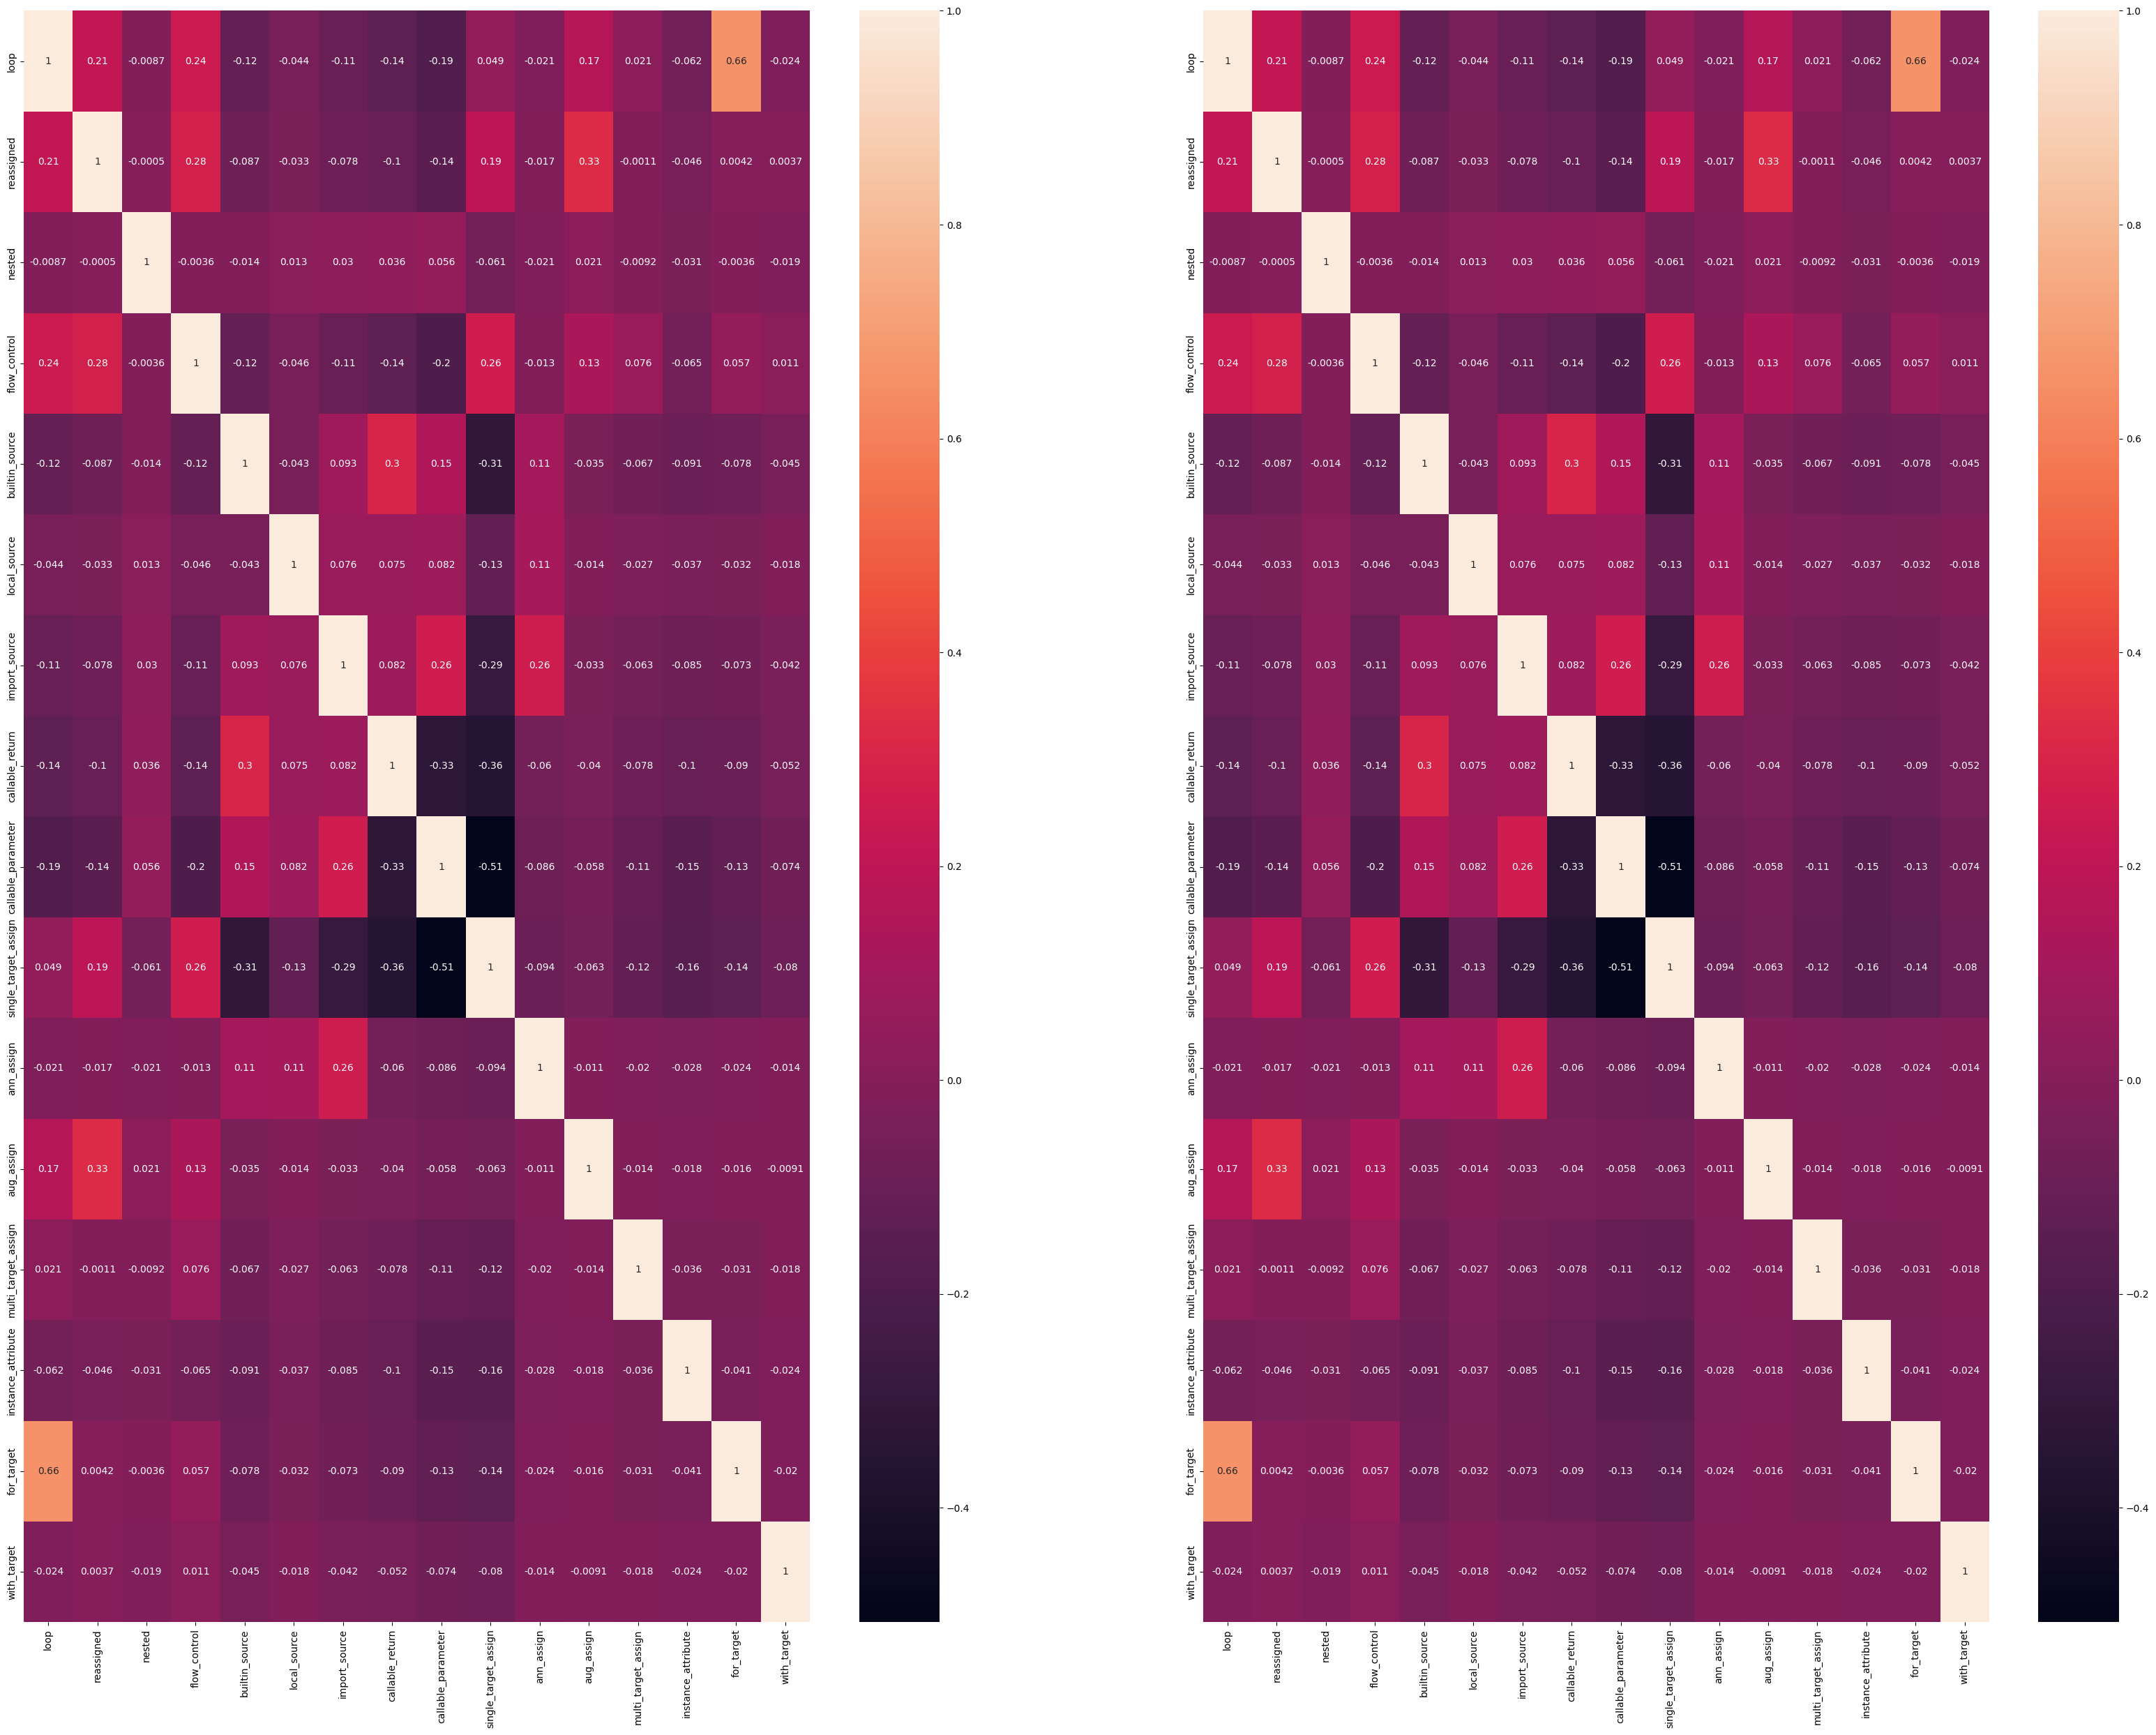

In [26]:
# Check if features correlate
feature_set = dummified_context.drop(columns=["file", "category", "qname", "qname_ssa", "repository"])

from matplotlib import pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 30))

sns.heatmap(feature_set.corr(method="pearson"), annot=True, ax=ax1)
sns.heatmap(feature_set.corr(method="spearman"), annot=True)

## Only annotated entities 

In [27]:
from scripts.common.output import DatasetIO
from scripts.common.schemas import TypeCollectionSchema

import pandas as pd
import tqdm

ground_truths_per_repo = [
    DatasetIO(artifact_root=pathlib.Path(), dataset=dataset, repository=project).read().assign(repository=project.name) 
    for project in tqdm.tqdm(dataset.test_set())
]
ground_truths = (
    pd.concat(ground_truths_per_repo, ignore_index=True)
    .drop_duplicates(subset=["repository", TypeCollectionSchema.file, TypeCollectionSchema.category, TypeCollectionSchema.qname_ssa], keep=False)
)

joined = pd.merge(
    left=dummified_context, 
    right=ground_truths, 
    on=["repository", TypeCollectionSchema.file, TypeCollectionSchema.category, TypeCollectionSchema.qname, TypeCollectionSchema.qname_ssa],
    how="inner",
    validate="1:1"
)
joined_with_only_annotations = joined[joined[TypeCollectionSchema.anno].notna()]

print(f"Context Count for all annotated entities: {joined_with_only_annotations.shape}")
# print(joined_with_only_annotations.head(n=20))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 115.43it/s]


Context Count for all annotated entities: (18487, 22)


In [28]:
# Check if features correlate
feature_set = joined_with_only_annotations.drop(columns=["file", "category", "qname", "qname_ssa", "repository", "anno"])
print(feature_set.columns)

Index(['loop', 'reassigned', 'nested', 'flow_control', 'builtin_source',
       'local_source', 'import_source', 'callable_return',
       'callable_parameter', 'single_target_assign', 'ann_assign',
       'aug_assign', 'multi_target_assign', 'instance_attribute', 'for_target',
       'with_target'],
      dtype='object')


<Axes: >

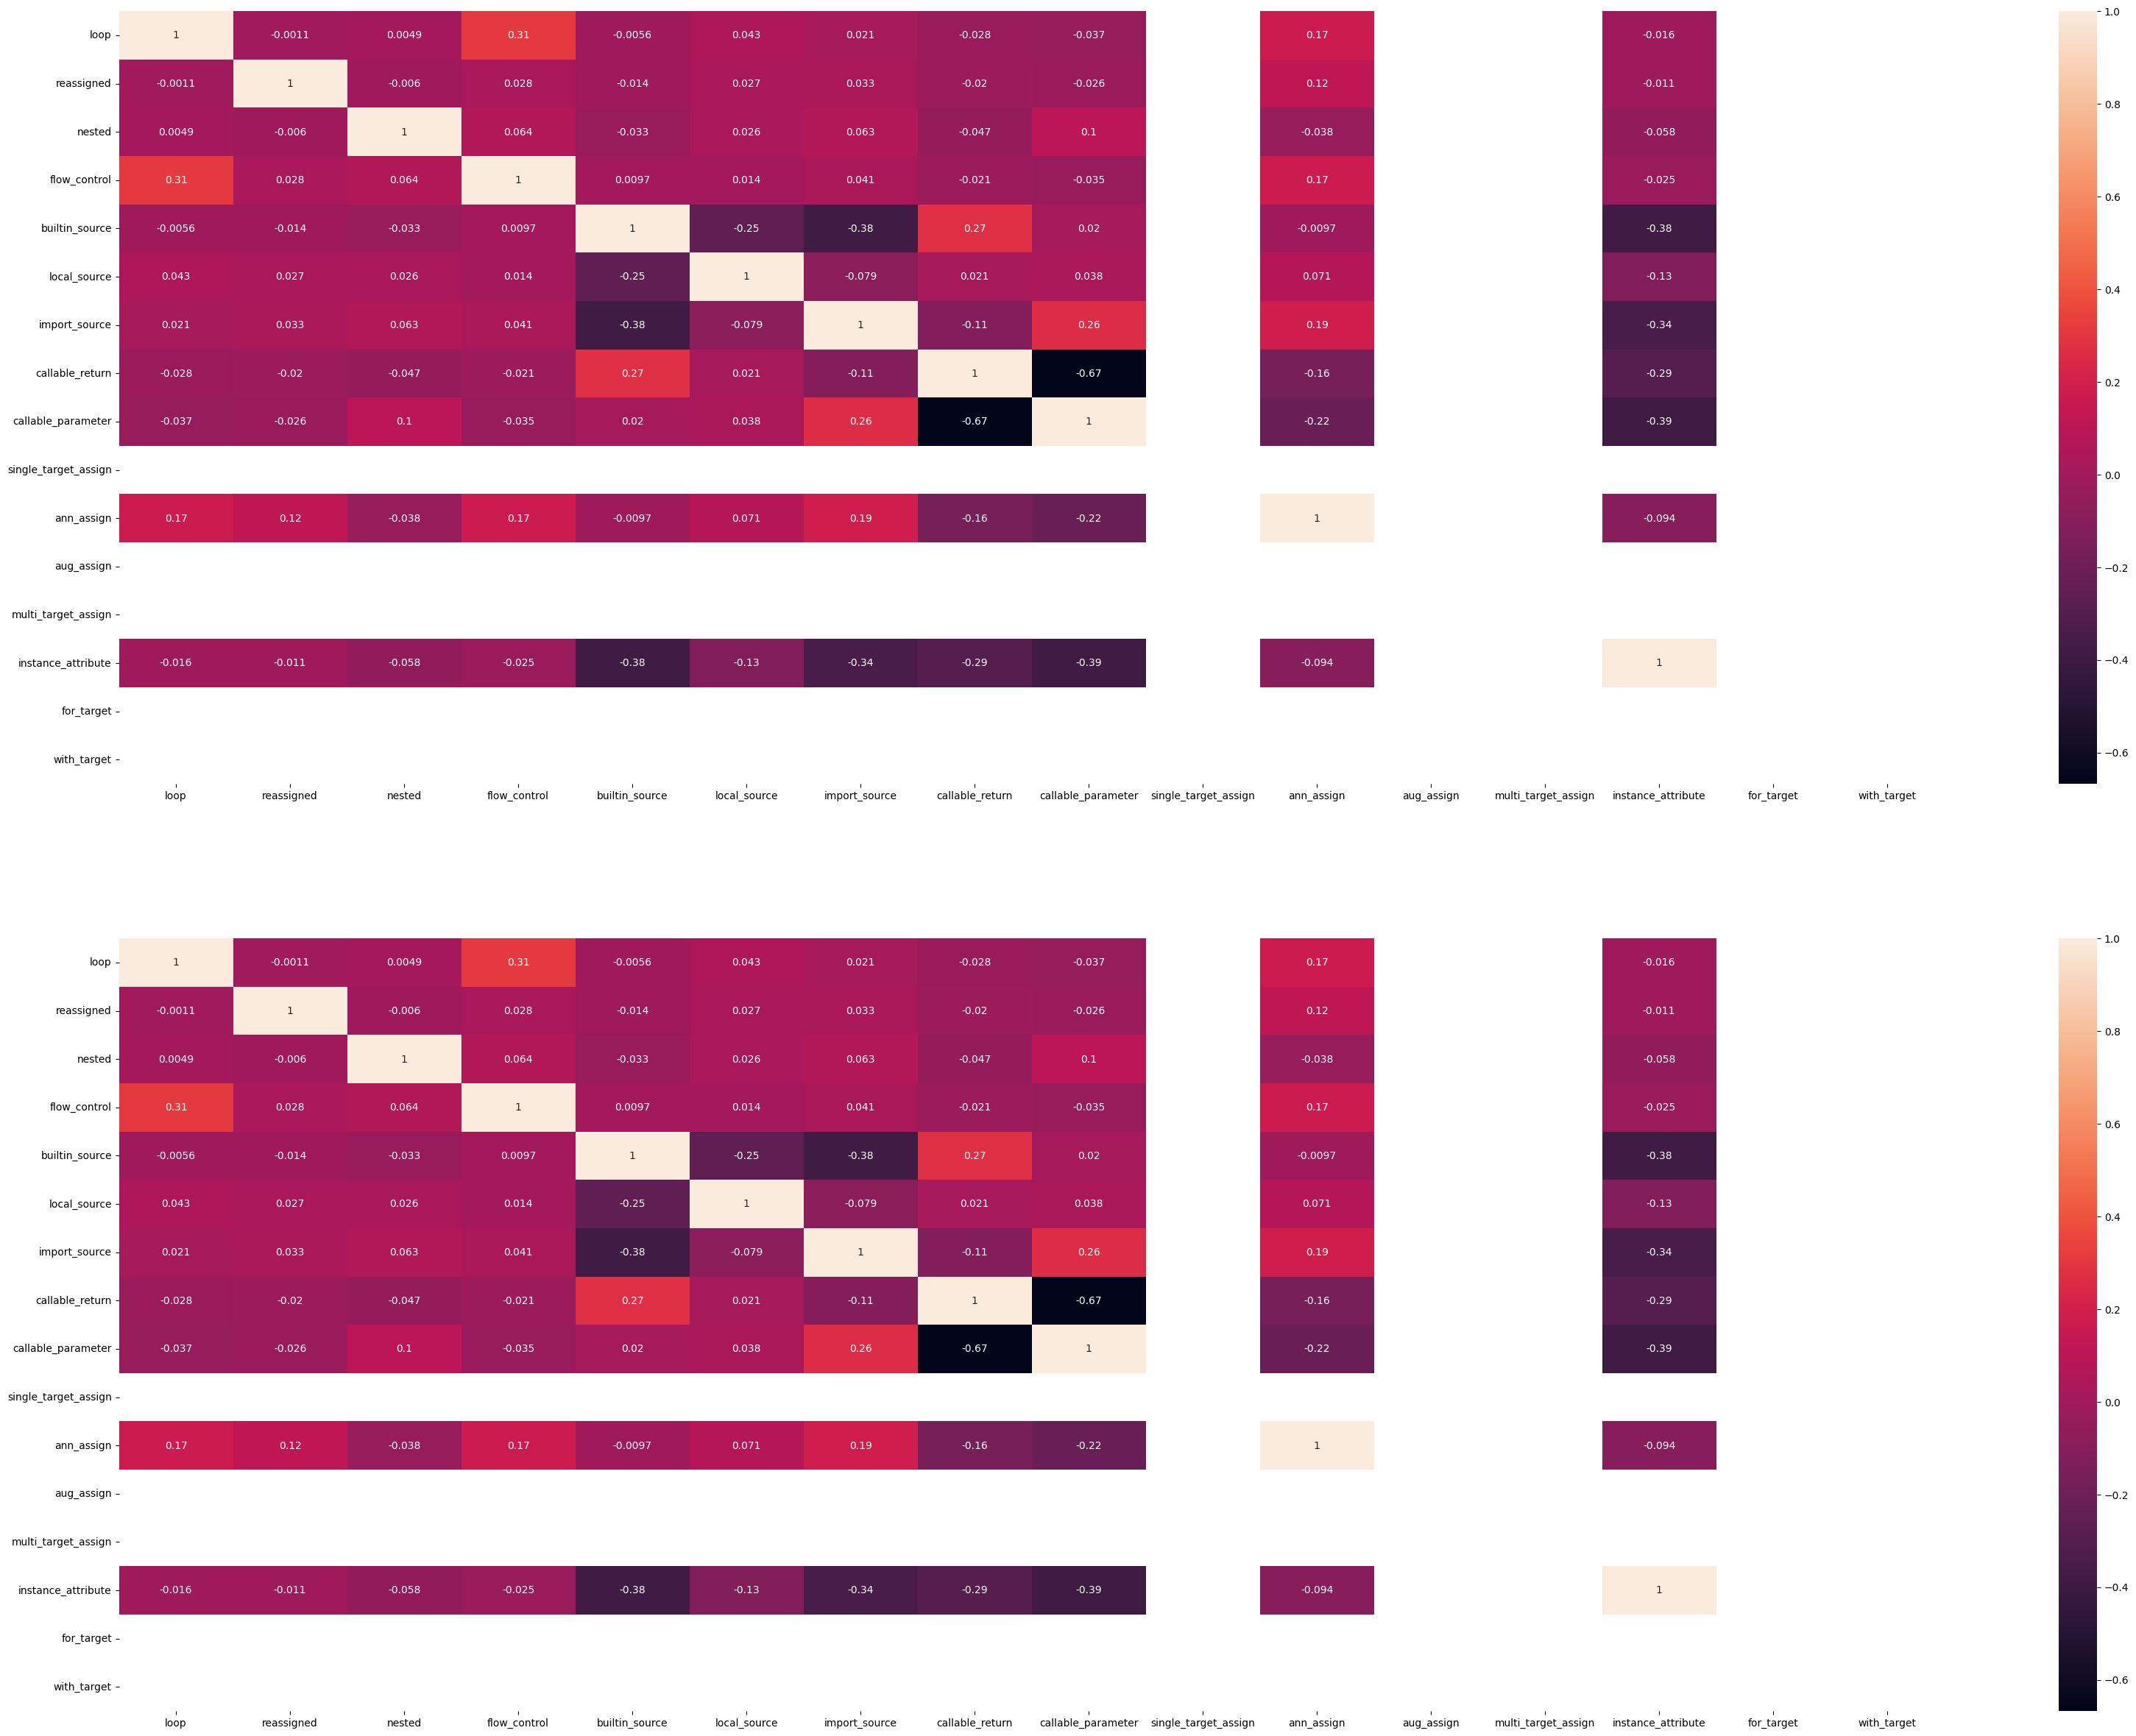

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 30))

sns.heatmap(feature_set.corr(method="pearson"), annot=True, ax=ax1)
sns.heatmap(feature_set.corr(method="spearman"), annot=True)